In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from scipy.linalg import sqrtm
import yfinance as yf

from cvxpylayers.torch import CvxpyLayer

import latexify
latexify.latexify()
%matplotlib inline

torch.set_default_dtype(torch.double)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


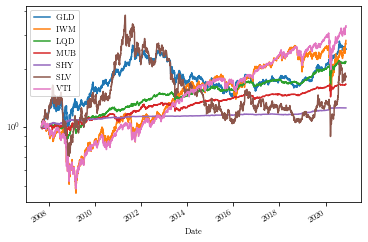

In [2]:
# get returns
df = yf.download("VTI IWM MUB GLD SLV LQD SHY")
df = df["Adj Close"].pct_change()
df = df[~df.isna().any(axis=1)]
(1 + df).cumprod(axis=0).plot()
plt.semilogy()
n = df.shape[1]

# get vix
aux = yf.download("^VIX")
aux = aux.loc[df.index]["Adj Close"].shift(-1)
aux = aux.iloc[:-1]
df = df.iloc[:-1]

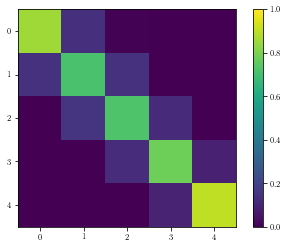

In [3]:
vix_codes = pd.qcut(aux, 5).cat.codes
P = np.zeros((5, 5))
for i in range(vix_codes.size - 1):
    P[vix_codes.iloc[i], vix_codes.iloc[i+1]] += 1
P /= P.sum(axis=1)[:, None]
plt.imshow(P, vmin=0, vmax=1)
plt.colorbar()

In [4]:
models = {}
for i in range(5):
    log1pr = np.log1p(df[vix_codes == i])
    mu, Sigma = np.array(log1pr.mean()), np.array(log1pr.cov())
    mean = np.exp(mu + .5 * np.diag(Sigma))
    cov = np.diag(mean) @ (np.exp(Sigma) - np.outer(np.ones(n), np.ones(n))) @ np.diag(mean)
    models[i] = (mu, Sigma, mean, cov)

In [5]:
np.set_printoptions(precision=4, suppress=True)
rets = np.array([df[vix_codes == i].mean() * 250 for i in range(5)])
rets

array([[-0.0817,  0.3773,  0.0268,  0.0097, -0.0021, -0.0283,  0.3874],
       [ 0.0012,  0.3539,  0.0423,  0.0336,  0.0024, -0.0823,  0.3148],
       [ 0.0308,  0.2736,  0.0656,  0.0419,  0.0109,  0.16  ,  0.2726],
       [ 0.2257, -0.0335,  0.0951,  0.0316,  0.0299,  0.3479, -0.0555],
       [ 0.259 , -0.4192,  0.0838,  0.0841,  0.0464,  0.0905, -0.3552]])

In [6]:
stds = np.array([df[vix_codes == i].std() * np.sqrt(250) for i in range(5)])
stds

array([[0.1216, 0.1118, 0.0453, 0.0247, 0.0076, 0.1851, 0.068 ],
       [0.151 , 0.1405, 0.0527, 0.0358, 0.0085, 0.2586, 0.1025],
       [0.1586, 0.1737, 0.0513, 0.0515, 0.0105, 0.2978, 0.1356],
       [0.1853, 0.2304, 0.0612, 0.0456, 0.0154, 0.3298, 0.183 ],
       [0.2616, 0.4623, 0.1732, 0.1021, 0.02  , 0.4562, 0.3908]])

In [7]:
vix_state = 0
R = []
for _ in range(252*5):
    mean, cov, _, _ = models[vix_state]
    R.append(np.exp(np.random.multivariate_normal(mean, cov)))
    vix_state = np.random.choice(np.arange(5), p=P[vix_state])
R = np.array(R)

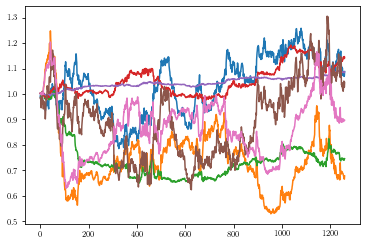

In [8]:
plt.plot(np.cumprod(R, axis=0))

## Optimization

In [9]:
n = df.shape[1]

In [10]:
wtilde = cp.Variable(n)
u = cp.Variable(n)
f = cp.Variable(n)

w = cp.Parameter(n)
alpha = cp.Parameter(n)
S = cp.Parameter((n, n))
s = cp.Parameter(1, nonneg=True)
kappa = cp.Parameter(1, nonneg=True)
gamma = cp.Parameter(1, nonneg=True)

expected_return = alpha @ wtilde
expected_risk = cp.sum_squares(f)
holding_cost = s * cp.sum(cp.neg(wtilde))
transaction_cost = kappa * cp.sum(cp.abs(u))

constraints = [
    cp.sum(wtilde) == 1,
    cp.norm(wtilde, 1) <= 1.5,
    cp.norm(wtilde, "inf") <= .5,
    f == S @ wtilde,
    u == wtilde - w
]

prob = cp.Problem(
    cp.Maximize(expected_return - gamma * expected_risk - holding_cost - transaction_cost),
    constraints
)

trading_policy = CvxpyLayer(prob, [w, alpha, S, s, kappa, gamma], [wtilde, u, f])

In [11]:
for i in range(5):
    _, _, mean, cov = models[i]
    w_tmp, _, _ = trading_policy(torch.zeros(n) / n, torch.from_numpy(mean), torch.from_numpy(sqrtm(cov)), torch.ones(1) * .0002, torch.zeros(1), torch.ones(1) * 5,
                                solver_args={"solve_method": "ECOS", "n_jobs_forward": 1})
    print(w_tmp.numpy())

[-0.25  0.5   0.25  0.    0.    0.    0.5 ]
[ 0.0859  0.5     0.1641  0.     -0.     -0.25    0.5   ]
[-0.0652  0.3243  0.2015  0.     -0.0074  0.0468  0.5   ]
[ 0.3833  0.      0.5     0.0247  0.049   0.1185 -0.0755]
[ 0.4075 -0.0645  0.131   0.5     0.2115 -0.0545 -0.1309]


In [12]:
def simulation(T, batch_size, params, seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    alpha_tch, S_tch, s_tch, kappa_tch, gamma_tch = params
    w_tch, _, _ = trading_policy(torch.zeros(batch_size, n) / n, alpha_tch[0], S_tch[0],
                                 s_tch[0], 0.*kappa_tch[0], gamma_tch[0],
                                 solver_args={"solve_method": "ECOS", "n_jobs_forward": 1})
    v = torch.ones(batch_size, 1)
    returns = torch.zeros(batch_size, 0)
    ws = []
    us = []
    vix_states = [0]*batch_size

    for t in range(T-1):
        ws.append(w_tch.detach().numpy())
        wtilde, u, _ = trading_policy(w_tch, alpha_tch[vix_states,:], S_tch[vix_states,:,:],
                                      s_tch[vix_states, :], kappa_tch[vix_states, :], gamma_tch[vix_states, :],
                                     solver_args={"solve_method": "ECOS", "n_jobs_forward": 1})
        us.append(u.detach().numpy())
        wtilde /= wtilde.sum(1).unsqueeze(1)
        u = wtilde - w_tch
        r = []
        for j in range(batch_size):
            mu, Sigma, _, _ = models[vix_states[j]]
            r += [np.exp(np.random.multivariate_normal(mu, Sigma)) - 1]
        r = torch.from_numpy(np.array(r))
        tc = .001 * u.abs().sum(1)
        sc = .0002 * (wtilde * (wtilde <= 0)).sum(1)
        total_return = 1 + (wtilde * r).sum(1) - tc - sc
        w_tch = wtilde * (1 + r)
        w_tch /= w_tch.sum(1).unsqueeze(1)
        v = torch.cat([v, (v[:, t] * total_return).unsqueeze(-1)], axis=1)
        returns = torch.cat([returns, total_return.unsqueeze(-1)], axis=1)
                
        for j in range(batch_size):
            vix_states[j] = np.random.choice(np.arange(5), p=P[vix_states[j]])

    realized_return = 100 * 252 * (returns - 1).mean()
    realized_volatility = 100 * np.sqrt(252) * (returns - 1).pow(2).mean(1).sqrt().mean()
    average_drawdown = 100 * (torch.cummax(v, 1).values / v - 1).mean()

    objective = -realized_return / realized_volatility + average_drawdown
    
    return objective, realized_return, realized_volatility, average_drawdown, v, np.array(ws), np.array(us)

In [13]:
T = 250*3
validation_seed = 538
batch_size = 8

s_tch = torch.log(torch.ones(5, 1) * .0002)
kappa_tch = torch.log(torch.ones(5, 1) * .001)
gamma_tch = torch.log(torch.ones(5, 1) * 5)

s_tch.requires_grad_(True)
kappa_tch.requires_grad_(True)
gamma_tch.requires_grad_(True);

In [14]:
alpha_tch = torch.from_numpy(np.array([np.array(df.mean())] * 5))
S_tch = torch.from_numpy(np.array([sqrtm(np.array(df.cov()))] * 5))

with torch.no_grad():
    params = [alpha_tch, S_tch, torch.exp(s_tch), torch.exp(kappa_tch), torch.exp(gamma_tch)]
    objective, ret, risk, drawdown, v0_common, w0_common, u0_common = simulation(T, batch_size, params, seed=validation_seed)
    print (objective.item(), ret.item(), risk.item(), drawdown.item())

1.453922342017236 9.226981464366146 7.938688084706391 2.6162027296472283


In [15]:
alpha_tch = []
S_tch = []
for j in range(5):
    _, _, mean, cov = models[j]
    alpha_tch.append(mean)
    S_tch.append(sqrtm(cov))
alpha_tch = torch.from_numpy(np.array(alpha_tch))
S_tch = torch.from_numpy(np.array(S_tch))

with torch.no_grad():
    params = [alpha_tch, S_tch, torch.exp(s_tch), torch.exp(kappa_tch), torch.exp(gamma_tch)]
    objective, ret, risk, drawdown, v0, w0, u0 = simulation(T, batch_size, params, seed=validation_seed)
    print (objective.item(), ret.item(), risk.item(), drawdown.item())

-0.5547333136893708 13.54432962825739 7.0873765163335785 1.356316508066692


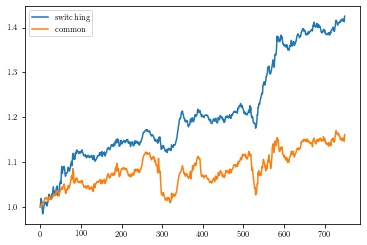

In [19]:
i = 6
plt.plot(v0[i], label='switching')
plt.plot(v0_common[i], label='common')
plt.legend()

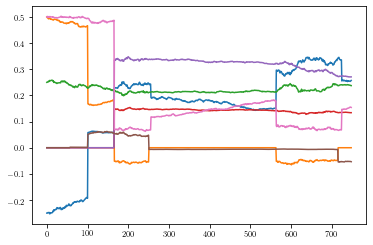

In [20]:
plt.plot(w0[:,1,:])

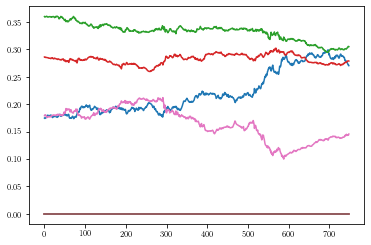

In [22]:
plt.plot(w0_common[:,i,:])

-0.5547333136893708 13.54432962825739 7.0873765163335785 1.356316508066692
s: [0.0002 0.0002 0.0002 0.0002 0.0002]
kappa: [0.001 0.001 0.001 0.001 0.001]
gamma: [5. 5. 5. 5. 5.]


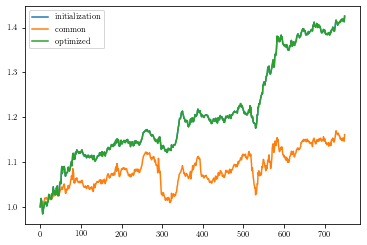

-1.1343370130159167 15.60917766555344 6.961221565928075 1.107967375333546
s: [0.00020574 0.0002064  0.00020003 0.00020296 0.00019025]
kappa: [0.00095123 0.00095123 0.00100699 0.00105127 0.00105127]
gamma: [5.25635548 5.25635545 4.76577928 5.25635548 5.25635548]


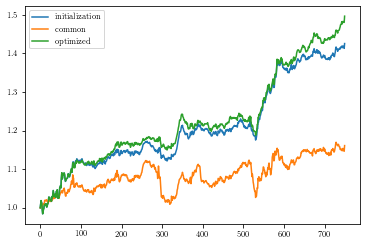

-1.20500538061797 16.330328635370382 6.991846836511527 1.1306190998974164
s: [0.00020752 0.00020466 0.00019992 0.00021065 0.00018288]
kappa: [0.00091097 0.00092092 0.00099299 0.00101592 0.00108302]
gamma: [5.44871542 5.43273051 4.94044897 5.51464917 5.52622973]


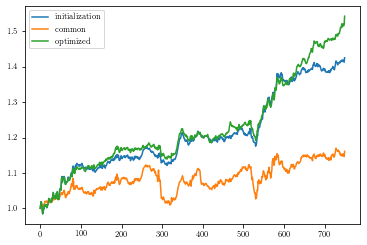

-1.1382565167166394 16.10340720060342 6.962893850260903 1.1744898136040534
s: [0.0002083  0.00020356 0.00019994 0.00020729 0.00017659]
kappa: [0.00088098 0.00092724 0.00098716 0.00100417 0.00110984]
gamma: [5.60199457 5.48851951 5.13017421 5.68987125 5.8049635 ]


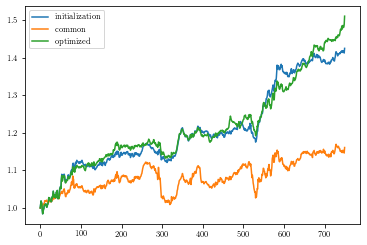

-1.1794794521396936 15.843407061825648 6.8345805007976255 1.1386448365385438
s: [0.00021121 0.00019917 0.00019991 0.00020461 0.00017142]
kappa: [0.00085913 0.00093671 0.00098227 0.00099341 0.00111174]
gamma: [5.74515587 5.51793333 5.24798147 5.85193753 6.09379055]


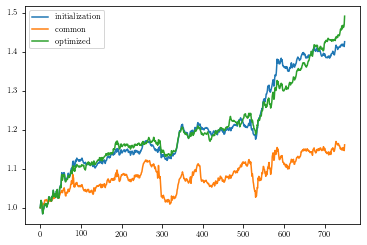

-1.2469681365873275 15.605732713150832 6.676262461579682 1.0905272514322637
s: [0.00021281 0.00019645 0.00019989 0.00020255 0.00016707]
kappa: [0.00084063 0.00092755 0.00097902 0.00098278 0.00110369]
gamma: [5.86407909 5.61468819 5.31877343 6.02177561 6.40054019]


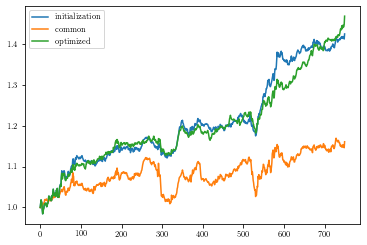

-1.3131741918064463 15.392459069978692 6.530546463433378 1.0438198447823752
s: [0.000214   0.00019439 0.00019983 0.00020079 0.00016303]
kappa: [0.00082493 0.00090866 0.00097666 0.00097047 0.00108901]
gamma: [5.96724801 5.75030672 5.428432   6.20946596 6.72583784]


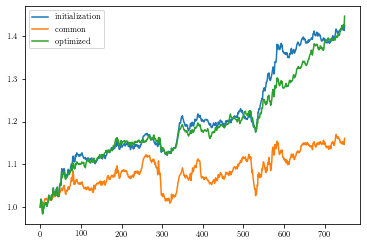

-1.3682426869936055 15.249633017332464 6.421660225508049 1.0064754515896284
s: [0.00020865 0.00019255 0.00019976 0.00019927 0.00015939]
kappa: [0.00081106 0.00089491 0.00097657 0.00095651 0.00107459]
gamma: [6.05600434 5.86383613 5.53015495 6.41366827 7.04215924]


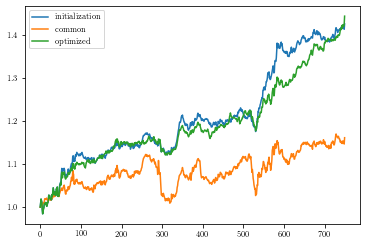

-1.4166012168827358 15.089485861315215 6.318284273100073 0.9716240052014146
s: [0.00020798 0.0001897  0.00019949 0.00019773 0.0001566 ]
kappa: [0.00079898 0.00090008 0.00098588 0.00094378 0.00105531]
gamma: [6.13186376 5.9242896  5.66961668 6.60353883 7.37810266]


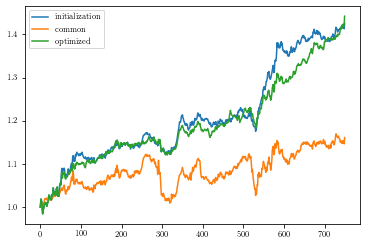

-1.4350673813854522 14.982029609753305 6.258300983677698 0.9588778201681328
s: [0.00020311 0.0001944  0.00019925 0.00019637 0.00015442]
kappa: [0.00078821 0.00090841 0.00100221 0.00093486 0.00103693]
gamma: [6.2045484  5.96559396 5.85919023 6.77699541 7.71162606]


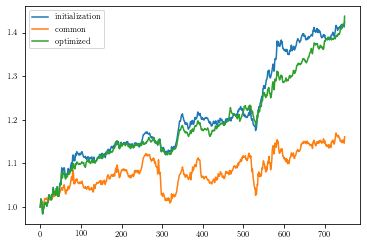

-1.4249473885031971 14.935487901738892 6.247664059816419 0.9656241529150776
s: [0.0002039  0.00019868 0.0001996  0.00019805 0.00015212]
kappa: [0.00077913 0.00091676 0.00102532 0.00092942 0.00102677]
gamma: [6.27304917 5.99898434 6.07584803 6.95056938 8.04510223]


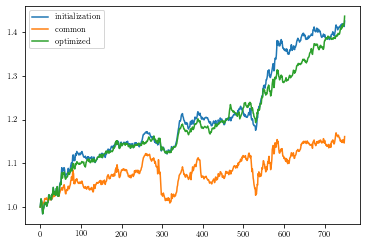

-1.4206313453196353 14.9581070880292 6.251995830107589 0.9719017744236308
s: [0.00020663 0.0002026  0.00019999 0.00020054 0.00014955]
kappa: [0.0007707  0.00092557 0.00105466 0.00093047 0.00102048]
gamma: [6.3290412  6.0226206  6.27640597 7.08902868 8.36167531]


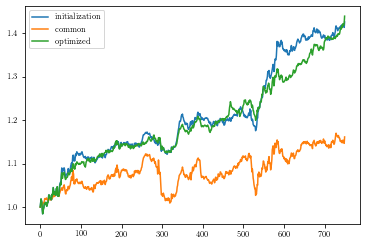

-1.4084852153697376 15.08481163047622 6.292472251817502 0.9887937914815301
s: [0.00020496 0.00020762 0.00020039 0.00020488 0.00014684]
kappa: [0.00076159 0.00094109 0.00107695 0.00093664 0.00101518]
gamma: [6.36133813 5.9708976  6.39193534 7.22454553 8.66979703]


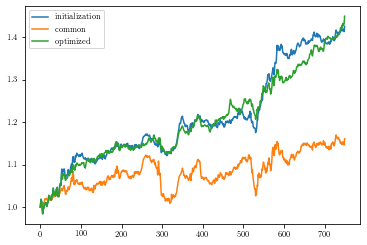

-1.3905288588429285 15.278711047182304 6.35825283853249 1.0124443218695092
s: [0.00020008 0.00021225 0.00020071 0.0002112  0.00014458]
kappa: [0.00075194 0.00095961 0.00109888 0.00094224 0.00100973]
gamma: [6.36903894 5.89441127 6.56348532 7.37866521 8.97226969]


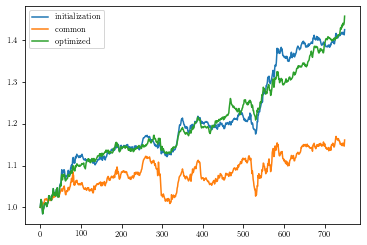

-1.4051529816875208 15.53913573601561 6.408498590613993 1.0196171132571075
s: [0.00019648 0.00021652 0.00020097 0.00021898 0.00014249]
kappa: [0.00074296 0.0009813  0.00111242 0.00094237 0.00100768]
gamma: [6.37089131 5.78846722 6.78900509 7.5599786  9.24886481]


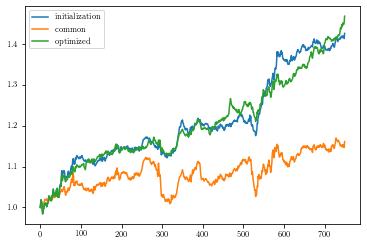

-1.3775728319494094 15.53682126068899 6.437444063802597 1.0359349370814244
s: [0.00019117 0.00022046 0.00019615 0.00021379 0.00014586]
kappa: [0.00074038 0.00096453 0.00114037 0.00096167 0.00098345]
gamma: [6.4169307  5.9145689  6.992066   7.38483844 9.48977003]


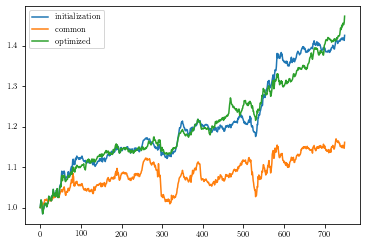

-1.3497072153174474 15.624877208862955 6.487599453956236 1.0587147780185733
s: [0.00018659 0.00022409 0.00019187 0.00020919 0.00014899]
kappa: [0.00073544 0.00094812 0.00116622 0.00097665 0.00096177]
gamma: [6.43928133 6.03792634 7.18114725 7.22986947 9.71550106]


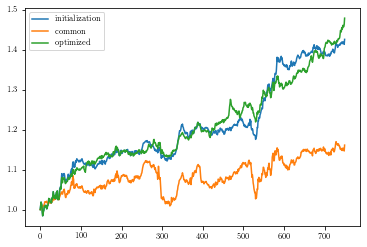

-1.4218140186431478 16.538022384254123 6.644850239709532 1.0670340046611448
s: [0.00018287 0.00022743 0.00019099 0.00020514 0.00015186]
kappa: [0.00072563 0.00093398 0.00118317 0.00098791 0.00094244]
gamma: [6.41865068 6.15004907 7.41436205 7.09348643 9.92603017]


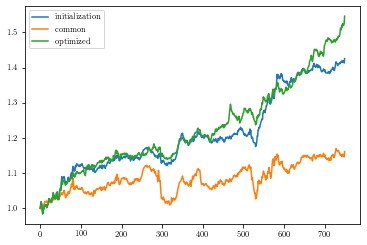

-1.467991194370234 17.233170466195816 6.7897343319629755 1.0701302730736246
s: [0.0001792  0.00023051 0.00019081 0.00020154 0.00015451]
kappa: [0.00071502 0.00092133 0.00119941 0.0009965  0.00092519]
gamma: [ 6.3691997   6.25367644  7.63775743  6.97278903 10.12159324]


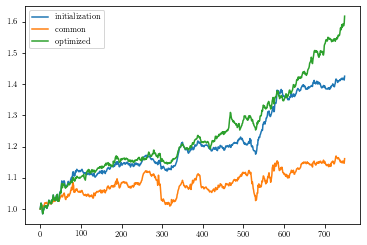

-1.4459959729050442 17.30726976656251 6.833108673364607 1.0868584852753276
s: [0.00017663 0.00023276 0.00019115 0.00019837 0.00015693]
kappa: [0.00070628 0.00090991 0.00121643 0.00100447 0.00090987]
gamma: [ 6.35910759  6.34992409  7.89038506  6.86644421 10.30281483]


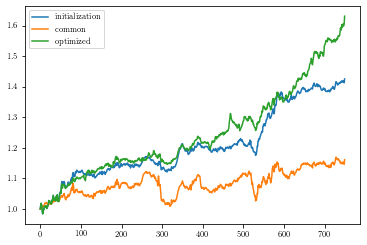

-1.4301913278525882 17.35491618034894 6.86004278848319 1.0996640557734156
s: [0.00017437 0.00023581 0.00019091 0.00019553 0.00015918]
kappa: [0.00069835 0.00089958 0.00123236 0.0010092  0.00089595]
gamma: [ 6.35430503  6.43821763  8.08741865  6.77147612 10.47319288]


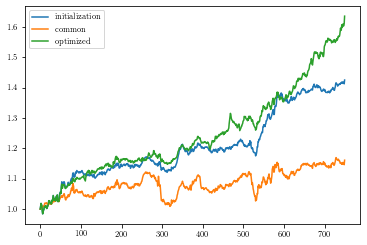

-1.4137710858830164 17.39752137332958 6.885690299569629 1.112848703336514
s: [0.00017229 0.00023332 0.00018836 0.00019297 0.00016124]
kappa: [0.00069114 0.00088975 0.00125302 0.00101435 0.00088342]
gamma: [ 6.34420644  6.52489496  8.28821156  6.68598765 10.63083233]


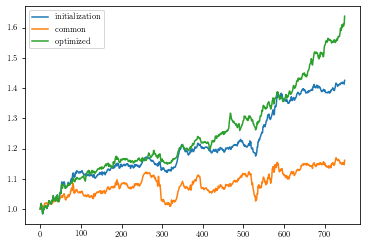

-1.4059218414507388 17.458785895514787 6.910200817600509 1.1206018235412663
s: [0.0001704  0.00022719 0.0001891  0.00019069 0.00016312]
kappa: [0.00068474 0.00087975 0.00126881 0.00101558 0.00087218]
gamma: [ 6.33765418  6.61465842  8.55983904  6.61040512 10.77767955]


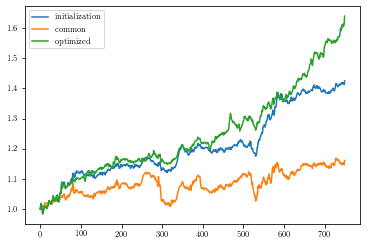

-1.4151395026173719 17.578435951672102 6.935940935096729 1.119258658520797
s: [0.0001684  0.00021926 0.00018949 0.00018864 0.00016486]
kappa: [0.00067888 0.00086884 0.00128319 0.00101204 0.00086205]
gamma: [ 6.31519369  6.71268097  8.80161557  6.54354668 10.91392982]


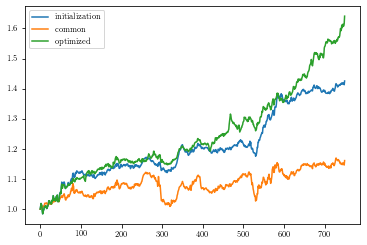

-1.4254248603377104 17.702772554152673 6.962085092366461 1.1173151836704815
s: [0.00016702 0.00021095 0.00018985 0.00018681 0.00016645]
kappa: [0.00067344 0.00085828 0.00129096 0.00100701 0.0008529 ]
gamma: [ 6.31170008  6.80872662  9.02569441  6.4841064  11.04107274]


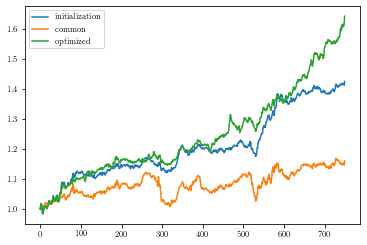

-1.4391437476638216 17.83223930454675 6.986515680313443 1.113235738836769
s: [0.00016633 0.00020184 0.00019022 0.00018519 0.00016791]
kappa: [0.00066825 0.00084707 0.00129954 0.0009987  0.00084455]
gamma: [ 6.32674771  6.90859063  9.23480402  6.43256977 11.15945324]


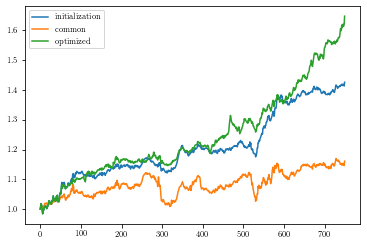

-1.456206392786724 17.948827432036133 7.004198268006987 1.1063748970692227
s: [0.00016593 0.00019397 0.00019057 0.00018375 0.00016925]
kappa: [0.000664   0.00083707 0.00130739 0.00098551 0.00083698]
gamma: [ 6.35767992  7.00057535  9.42951817  6.38802836 11.26952728]


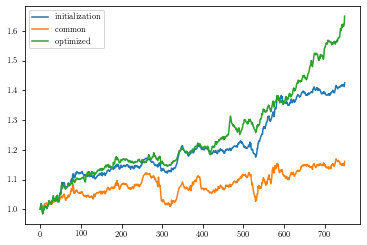

-1.4766182263819951 18.07539139896608 7.022301060422146 1.0973801316262382
s: [0.0001659  0.0001856  0.00019111 0.00018247 0.00017049]
kappa: [0.00066021 0.00082581 0.0013134  0.00097023 0.00083009]
gamma: [ 6.40257101  7.08992895  9.62059489  6.34973671 11.37113032]


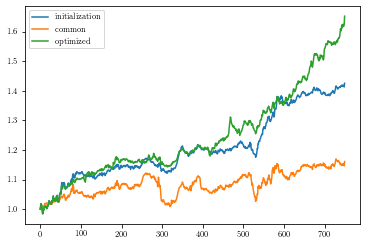

-1.4881256862752545 18.147362094072967 7.034693874361195 1.0915689554792722
s: [0.00016563 0.00017897 0.00019161 0.00018135 0.00017161]
kappa: [0.00065786 0.00081729 0.0013178  0.00095311 0.00082382]
gamma: [ 6.45873809  7.17471409  9.7982125   6.31758449 11.46596647]


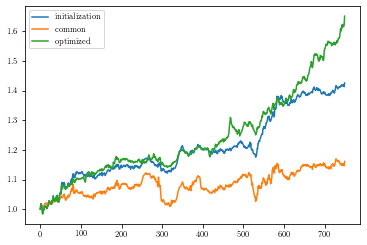

-1.4988347787841927 18.1982835212755 7.0405862684851765 1.0859334247862988
s: [0.00016549 0.00017456 0.00019207 0.00018035 0.00017265]
kappa: [0.00065613 0.00081036 0.00132189 0.00093759 0.0008181 ]
gamma: [ 6.52535056  7.2487545   9.96290829  6.28905129 11.55359318]


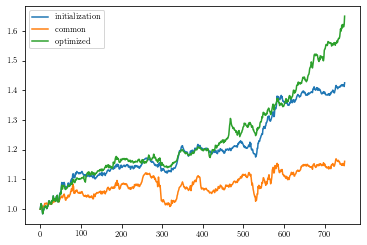

-1.5114846010315743 18.17326897948641 7.021876711001158 1.0766082589604544
s: [0.00016501 0.00017487 0.00019249 0.00017947 0.00017359]
kappa: [0.00065692 0.00080767 0.00132393 0.00091797 0.00081303]
gamma: [ 6.62833863  7.30875206 10.11490222  6.26794351 11.63403812]


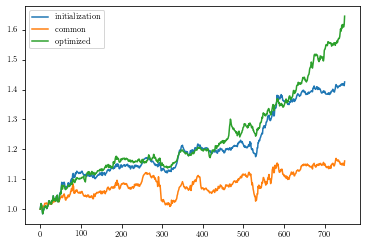

-1.5223731945342471 18.146888282647616 7.007488691052596 1.0672689843847414
s: [0.00016446 0.00017608 0.00019287 0.0001787  0.00017445]
kappa: [0.0006574  0.00080574 0.00129637 0.00090052 0.0008084 ]
gamma: [ 6.71219993  7.35893824 10.26147776  6.24893212 11.70830904]


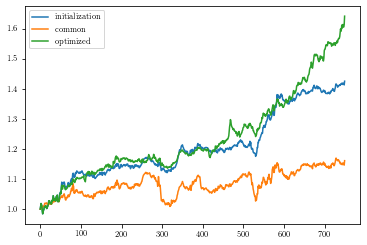

-1.5285855858889945 18.090130470645253 6.987311836466049 1.060411569817547
s: [0.00016381 0.00017848 0.00019321 0.00017799 0.00017525]
kappa: [0.00065917 0.00080642 0.0012719  0.0008827  0.00080421]
gamma: [ 6.81501948  7.39905884 10.39686191  6.23231149 11.77772381]


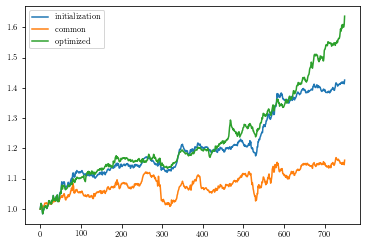

-1.5316773479616874 18.03002390682751 6.967176106169093 1.0561751236964934
s: [0.00016349 0.00018063 0.00019353 0.00017737 0.00017597]
kappa: [0.00066126 0.00080727 0.00125015 0.00086681 0.00080033]
gamma: [ 6.93494147  7.43764698 10.52175333  6.21753313 11.84212999]


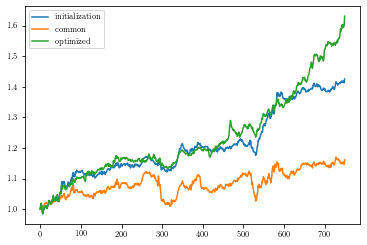

-1.5327384858417719 17.96234458598795 6.94720534361408 1.0528111988957125
s: [0.00016281 0.00018391 0.00019382 0.0001768  0.00017662]
kappa: [0.00066333 0.00080959 0.00123075 0.0008536  0.00079662]
gamma: [ 7.02983029  7.47024774 10.6368144   6.2047834  11.90214291]


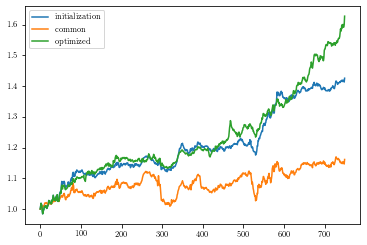

-1.5399608544483876 17.910053265214355 6.926335428169427 1.0458297776908119
s: [0.00016191 0.00018856 0.00019408 0.0001763  0.00017722]
kappa: [0.00066527 0.00081356 0.00121333 0.00084175 0.00079313]
gamma: [ 7.10300286  7.49463915 10.74270698  6.19378022 11.96049228]


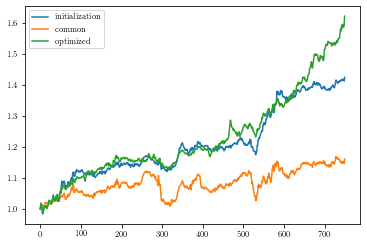

-1.5460170103556545 17.875605332918 6.910965803076101 1.0405397520814406
s: [0.00016079 0.00019258 0.0001943  0.00017585 0.00017776]
kappa: [0.00066704 0.00081649 0.00119772 0.0008298  0.0007899 ]
gamma: [ 7.15423487  7.51604786 10.83908388  6.18372707 12.01404981]


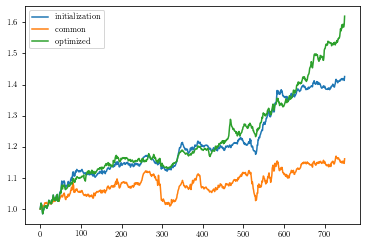

-1.5531743938746108 17.83702156510921 6.893738475115813 1.0342491977651276
s: [0.00015962 0.00019727 0.0001945  0.00017543 0.00017825]
kappa: [0.00066875 0.0008211  0.00118354 0.00082101 0.00078693]
gamma: [ 7.1949159   7.5363061  10.92583603  6.17573215 12.06467782]


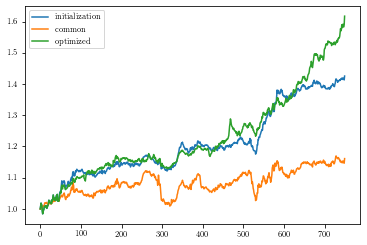

-1.5589213657738765 17.7872990202966 6.874701331940523 1.0284345296240953
s: [0.00015839 0.00020292 0.00019469 0.00017505 0.00017869]
kappa: [0.00067036 0.00082706 0.00117072 0.00081276 0.00078414]
gamma: [ 7.22291561  7.55051923 11.00537586  6.1680633  12.11337584]


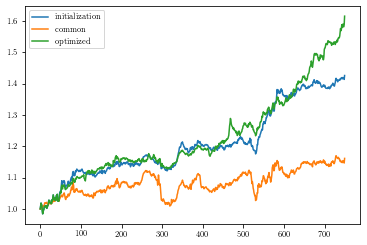

-1.5633535263004115 17.766132606097067 6.864651460214776 1.0247068740074017
s: [0.00015746 0.00020554 0.00019483 0.0001747  0.00017909]
kappa: [0.00067175 0.00082969 0.00115937 0.00080533 0.00078156]
gamma: [ 7.25810947  7.57365613 11.0772009   6.16141793 12.15875099]


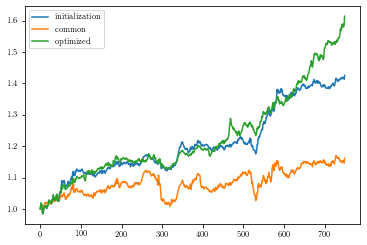

-1.5674424724532452 17.750684182065957 6.856526641118911 1.0214316195125428
s: [0.00015647 0.00020757 0.00019496 0.00017439 0.00017947]
kappa: [0.00067306 0.00083224 0.00114909 0.00079765 0.00077915]
gamma: [ 7.28152592  7.59843149 11.1429809   6.15533637 12.203028  ]


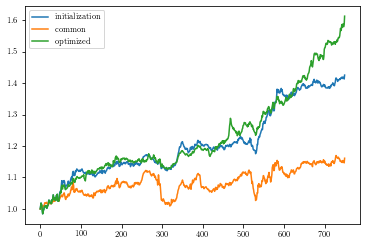

-1.570963661125963 17.747779847097487 6.852768387529978 1.0189064239907648
s: [0.00015535 0.00020851 0.00019508 0.0001741  0.00017981]
kappa: [0.00067422 0.0008334  0.00113985 0.00079053 0.00077692]
gamma: [ 7.28919113  7.62537124 11.20379739  6.15078506 12.24629829]


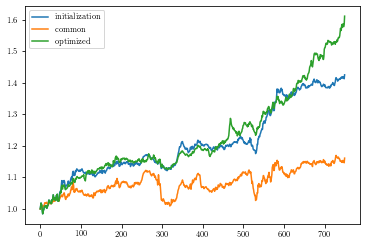

-1.573838074287892 17.746956789290042 6.849678224330699 1.0170802445100902
s: [0.0001543  0.00020944 0.00019519 0.00017385 0.00018012]
kappa: [0.00067526 0.00083412 0.0011316  0.00078474 0.00077477]
gamma: [ 7.29306305  7.6480839  11.25949807  6.14725693 12.28791044]


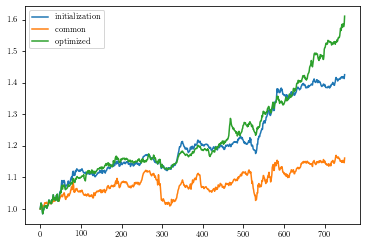

-1.5759176509919919 17.747877361183626 6.847946454512815 1.0157903127126202
s: [0.00015336 0.00021007 0.00019526 0.00017361 0.00018041]
kappa: [0.00067623 0.00083446 0.00112474 0.00077898 0.00077279]
gamma: [ 7.29835739  7.66570103 11.30803764  6.1443707  12.32780085]


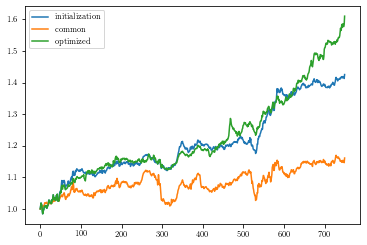

-1.578704977932227 17.736136533025938 6.842017158013479 1.013532972282951
s: [0.00015211 0.0002117  0.00019528 0.00017339 0.00018067]
kappa: [0.0006772  0.00083695 0.00111863 0.00077559 0.00077084]
gamma: [ 7.2784774   7.67645808 11.35036255  6.14105978 12.36679589]


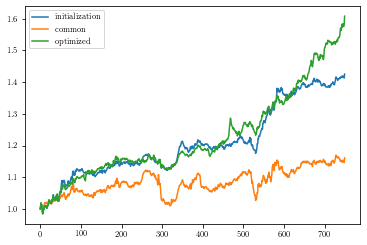

-1.579529680200026 17.679982808322997 6.82401704404794 1.0113171324913157
s: [0.00014945 0.0002185  0.0001953  0.00017319 0.0001809 ]
kappa: [0.00067805 0.00084928 0.00111314 0.00076963 0.00076894]
gamma: [ 7.1628867   7.62531762 11.3889983   6.12982587 12.40520993]


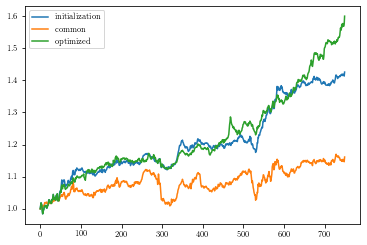

-1.582647498521651 17.62371793018672 6.8047904877660015 1.0072511856291009
s: [0.00014716 0.0002255  0.00019531 0.00017301 0.0001811 ]
kappa: [0.00067883 0.00086088 0.00110802 0.00076265 0.00076714]
gamma: [ 7.06551523  7.56372832 11.42418926  6.11977454 12.4429636 ]


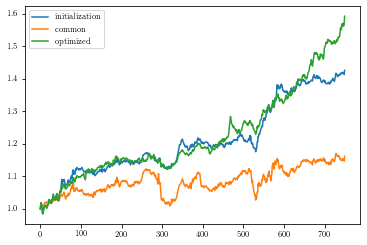

-1.5786285951230348 17.4834668207908 6.762727549797937 1.0066399510441382
s: [0.00014353 0.00023436 0.0001952  0.00017283 0.00018127]
kappa: [0.0006795  0.00088313 0.00110404 0.00076211 0.00076528]
gamma: [ 6.88140541  7.4807503  11.43643755  6.10233076 12.47964312]


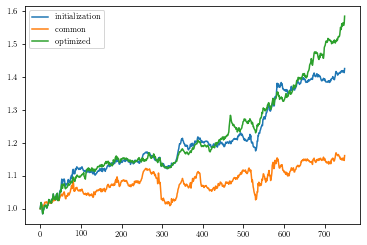

-1.564280747557407 17.3561091634997 6.73969796932349 1.0109250320632859
s: [0.00014062 0.00024222 0.00019499 0.00017267 0.00018143]
kappa: [0.00068054 0.00090337 0.00110033 0.00076226 0.00076352]
gamma: [ 6.74517646  7.41349441 11.44265319  6.0883555  12.51495791]


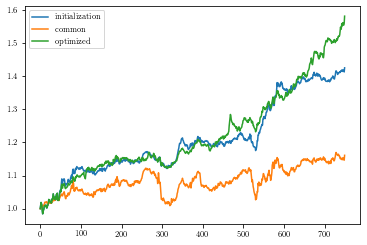

-1.553141584874502 17.291867344733593 6.732217922564369 1.0153830148382397
s: [0.00013805 0.00024936 0.00019491 0.00017254 0.00018157]
kappa: [0.0006818  0.00092177 0.00109727 0.00076188 0.00076191]
gamma: [ 6.63251773  7.35673896 11.45511006  6.07609953 12.54953793]


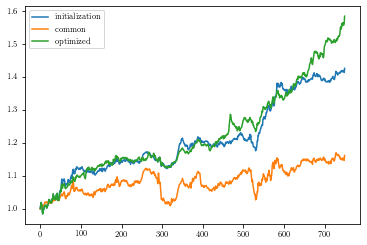

In [23]:
np.set_printoptions(precision=8, suppress=True)
opt = torch.optim.Adam([s_tch, kappa_tch, gamma_tch], lr=5e-2)
objectives, rets, risks, drawdowns = [], [], [], []
vs = []
for k in range(50):
    # validation
    with torch.no_grad():
        params = [alpha_tch, S_tch, torch.exp(s_tch), torch.exp(kappa_tch), torch.exp(gamma_tch)]
        objective, ret, risk, drawdown, v, u, w = simulation(T, batch_size, params, seed=validation_seed)
        objectives.append(objective)
        rets.append(ret.item())
        risks.append(risk.item())
        drawdowns.append(drawdown.item())
        vs.append(v)
        print (objective.item(), ret.item(), risk.item(), drawdown.item())
    print("s:", np.exp(s_tch.detach().numpy().flatten()))
    print("kappa:", np.exp(kappa_tch.detach().numpy().flatten()))
    print("gamma:", np.exp(gamma_tch.detach().numpy().flatten()))
    opt.zero_grad()
    params = [alpha_tch, S_tch, torch.exp(s_tch), torch.exp(kappa_tch), torch.exp(gamma_tch)]
    objective, ret, risk, drawdown, _, _, _ = simulation(T, batch_size, params, seed=k)
    objective.backward()
    opt.step()
    
    plt.plot(v0[6], label='initialization')
    plt.plot(v0_common[6], label='common')
    plt.plot(v[6], label='optimized')
    plt.legend()
    plt.show()

In [24]:
# value versus time
# optimized (50 steps), optimized (10 steps), un-optimized, disregards VIX

In [25]:
# risk, return, drawdown versus 50 iterations of learning, stack of 3 plots

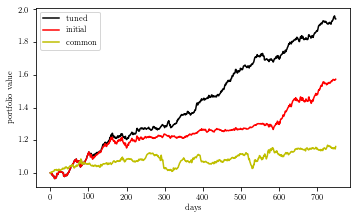

In [38]:
latexify.latexify(5)
plt.plot(v[1], c='k', label='tuned')
plt.plot(v0[1], c='r', label='initial')
plt.plot(v0_common[i], c='y', label='common')
plt.ylabel("portfolio value")
plt.xlabel("days")
plt.legend()
plt.tight_layout()
plt.savefig("figs/portfolio_value.pdf")
plt.show()

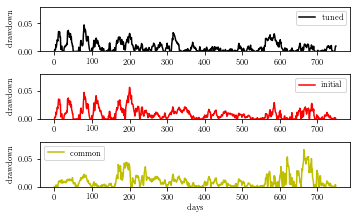

In [37]:
latexify.latexify(5)
fig, ax = plt.subplots(3, 1)
ax[0].plot(torch.cummax(v[1], 0).values / v[1] - 1, c='k', label='tuned')
ax[1].plot(torch.cummax(v0[1], 0).values / v0[1] - 1, c='r', label='initial')
ax[2].plot(torch.cummax(v0_common[1], 0).values / v0_common[1] - 1, c='y', label='common')
ax[0].set_ylabel("drawdown")
ax[1].set_ylabel("drawdown")
ax[2].set_ylabel("drawdown")
ax[0].set_ylim(0, .08)
ax[1].set_ylim(0, .08)
ax[2].set_ylim(0, .08)
ax[2].set_xlabel("days")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.savefig("figs/drawdown.pdf")
plt.show()

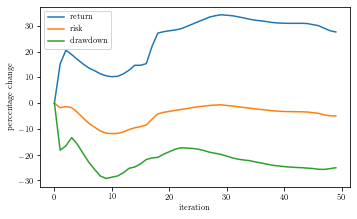

In [39]:
latexify.latexify(5)
plt.plot((np.array(rets) / rets[0] - 1) * 100, label='return')
plt.plot((np.array(risks) / risks[0] - 1) * 100, label='risk')
plt.plot((np.array(drawdowns) / drawdowns[0] - 1) * 100, label='drawdown')
plt.xlabel("iteration")
plt.ylabel("percentage change")
plt.legend()
plt.tight_layout()
plt.savefig("figs/objectives.pdf")